In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Data Preparation

In [2]:
df_train = pd.read_csv('train_data.csv') 
df_test = pd.read_csv('test_data.csv')

In [3]:

df_train = df_train.drop(columns=[
     'averageRating', 'originalTitle', 
])

df_test = df_test.drop(columns=[
     'averageRating', 'originalTitle', 
])

In [4]:
my_dict = {
    '(0, 1]': 0,
    '(1, 2]': 0,
    '(2, 3]': 0,
    '(3, 4]': 0,
    '(4, 5]': 1,
    '(5, 6]': 1,
    '(6, 7]': 2,
    '(7, 8]': 3,
    '(8, 9]': 4,
    '(9, 10]': 5,
}
df_train['rating'] = df_train['rating'].map(my_dict)
df_test['rating'] = df_test['rating'].map(my_dict)


In [5]:
X_train = df_train.drop(columns=["rating"])
y_train = df_train["rating"]
X_test = df_test.drop(columns=["rating"])
y_test = df_test["rating"]

In [6]:

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)


# Normalization

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)    # Transform validation data
X_test  = scaler.transform(X_test)   # Transform test data

# Keras Deep Neural Networks

In [9]:
# !pip install scikeras

In [10]:
from scikeras.wrappers import KerasClassifier

In [11]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.optimizers import Adam

In [12]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

  
    act_1 = hp.Choice('activation_1', ['relu', 'tanh'])
    dropout_1 = hp.Float('dropout_1', 0.2, 0.5, step=0.1)
    model.add(Dense(32, activation=act_1,
                    input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_1))

    act_2 = hp.Choice('activation_2', ['relu', 'tanh'])
    dropout_2 = hp.Float('dropout_2', 0.2, 0.5, step=0.1)
    model.add(Dense(16, activation=act_2))
    model.add(Dropout(dropout_2))

    
    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Optimizer
    lr = hp.Choice('learning_rate', [0.001, 0.01, 0.1])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [13]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=150,
    executions_per_trial=1,
    directory='my_dir',
    project_name='small_2_layers'
    

)

c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)
mc = ModelCheckpoint('best_model_2_layers_dropout.keras', monitor='val_accuracy', save_best_only=True)

In [16]:
tuner.search(X_train, y_train,
             epochs=500, 
             validation_data=(X_val, y_val),
             callbacks=[es, mc],)

Trial 89 Complete [00h 09m 01s]
val_accuracy: 0.4123746156692505

Best val_accuracy So Far: 0.421875
Total elapsed time: 07h 28m 27s


In [17]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
test_loss, test_accuracy


c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(1.3467564582824707, 0.42302238941192627)

In [18]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,334 (5.21 KB)

 Trainable params: 1,334 (5.21 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

activation_1: tanh
dropout_1: 0.2
activation_2: relu
dropout_2: 0.2
learning_rate: 0.001


<retrain best model on wrapper 

In [39]:
def build_model():
# 1. Build model using best hyperparameters
    model = Sequential([       
        Dense(32, activation='tanh', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='softmax')
    ])

# 2. Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [40]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
es = EarlyStopping(monitor='val_accuracy', patience=50, verbose=True)
mc = ModelCheckpoint('mdel_l2_3layers_best.keras', monitor='val_accuracy', save_best_only=True)


In [42]:
from scikeras.wrappers import KerasClassifier

In [43]:
clf = KerasClassifier(build_fn=build_model, callbacks=[es, mc])

In [44]:
clf.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500


c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3457 - loss: 1.5708 - val_accuracy: 0.3996 - val_loss: 1.4094
Epoch 2/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3945 - loss: 1.4287 - val_accuracy: 0.4016 - val_loss: 1.3986
Epoch 3/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4016 - loss: 1.4109 - val_accuracy: 0.4042 - val_loss: 1.3898
Epoch 4/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4056 - loss: 1.4027 - val_accuracy: 0.4065 - val_loss: 1.3850
Epoch 5/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4091 - loss: 1.4002 - val_accuracy: 0.4095 - val_loss: 1.3808
Epoch 6/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4070 - loss: 1.3969 - val_accuracy: 0.4099 - val_loss: 1.3774
Epoch 7/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4080 - loss: 1.3935 - val_accuracy: 0.4113 - val_loss: 1.3762
Epoch 8/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4086 - loss: 1.3936 - val_

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x0000026FB36A3010>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x0000026FB78DE9E0>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x0000026FB78DF580>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [45]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy 0.42290986834702377
F1-score [0.         0.49474322 0.2399174  0.54671001 0.0382072  0.        ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1547
           1       0.49      0.50      0.49      9052
           2       0.40      0.17      0.24     11574
           3       0.40      0.85      0.55     14409
           4       0.56      0.02      0.04      6571
           5       0.00      0.00      0.00      1282

    accuracy                           0.42     44435
   macro avg       0.31      0.26      0.22     44435
weighted avg       0.42      0.42      0.35     44435



c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


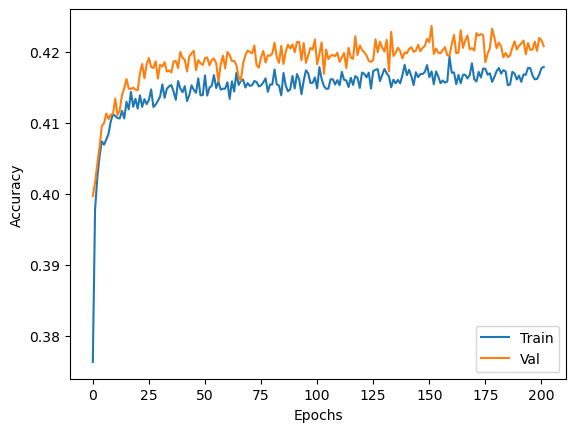

In [46]:
history = clf.history_
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

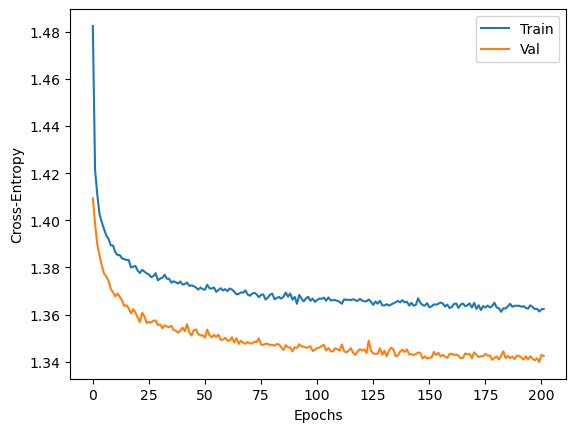

In [47]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

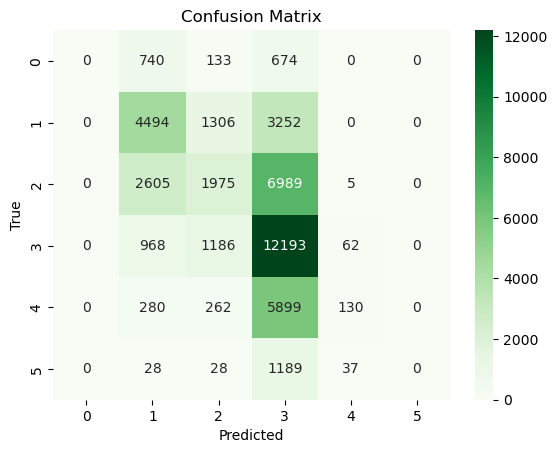

In [48]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')  # fmt='d' to show integer values
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [49]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


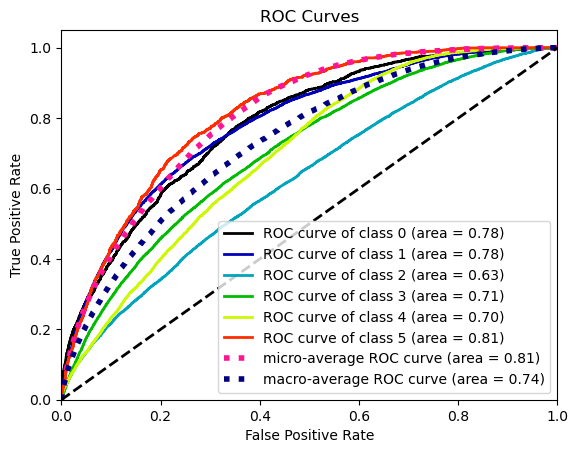

In [50]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


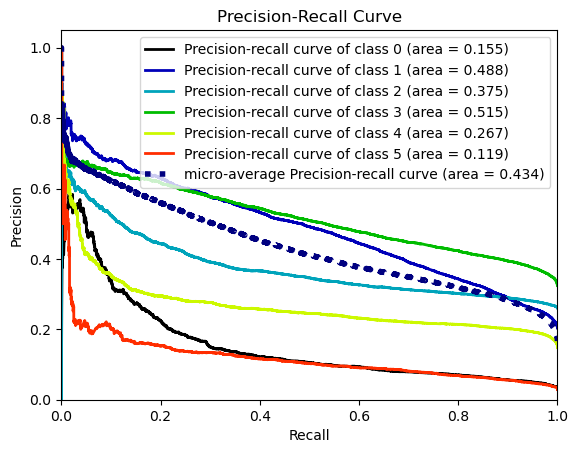

In [51]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

In [52]:
import numpy as np
from sklearn.metrics import f1_score
import random

def predict_with_thresholds(probs, thresholds, default_class=None):
    preds = []
    for p in probs:
        passed = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if passed:
            selected = passed[np.argmax([p[i] for i in passed])]
        else:
            selected = default_class if default_class is not None else np.argmax(p)
        preds.append(selected)
    return np.array(preds)

def random_search_thresholds(probs, y_true, n_iter=1000):
    n_classes = probs.shape[1]
    best_f1 = 0
    best_thresh = [0.5] * n_classes
    random.seed(42)

    for _ in range(n_iter):
        thresholds = [round(random.uniform(0.1, 0.9), 2) for _ in range(n_classes)]
        y_pred = predict_with_thresholds(probs, thresholds)
        f1 = f1_score(y_true, y_pred, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresholds

    return best_thresh, best_f1


In [53]:
probs_test = clf.predict_proba(X_test)  # ✅
probs_test.shape  # → (n_samples, n_classes)

best_thresh, best_f1 = random_search_thresholds(probs_test, y_test, n_iter=1000)

print("Best thresholds:", best_thresh)
print("Best macro F1 on test set:", best_f1)

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step
Best thresholds: [0.15, 0.72, 0.47, 0.33, 0.14, 0.26]
Best macro F1 on test set: 0.2760153840922631


In [54]:
probs_test = clf.predict_proba(X_test)  # shape: (n_samples, 6)
y_pred = predict_with_thresholds(probs_test, best_thresh)

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [55]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4012827725891752
F1-score [0.16981132 0.47768341 0.23109737 0.54012166 0.23737855 0.        ]
              precision    recall  f1-score   support

           0       0.31      0.12      0.17      1547
           1       0.49      0.46      0.48      9052
           2       0.41      0.16      0.23     11574
           3       0.45      0.67      0.54     14409
           4       0.20      0.28      0.24      6571
           5       0.00      0.00      0.00      1282

    accuracy                           0.40     44435
   macro avg       0.31      0.28      0.28     44435
weighted avg       0.39      0.40      0.37     44435



c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


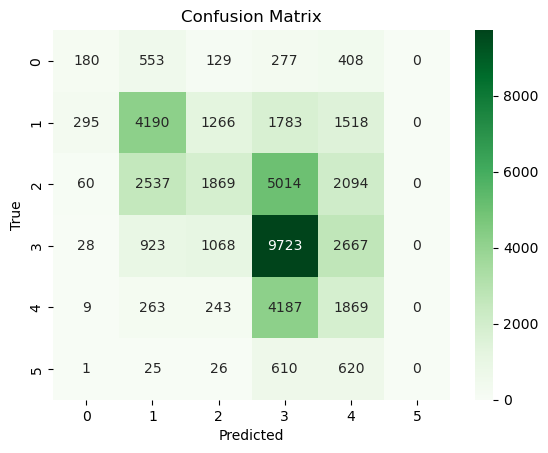

In [56]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')  # fmt='d' to show integer values
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


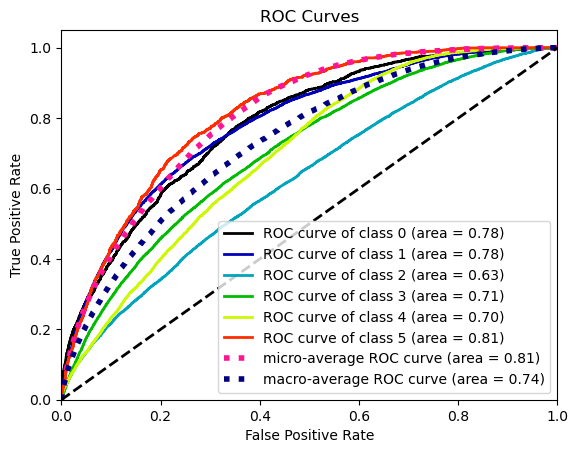

In [57]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()